<a href="https://colab.research.google.com/github/JunHyeong-data/ML-DL-Study/blob/main/Basic-Deep-Learning/06_%EB%94%A5%EB%9F%AC%EB%8B%9D%2C_torch_nn%2C_%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Classification (3)
## PyTorch Refactoring: BCEWithLogitsLoss, nn.Module, Sequential

---

## 1. 이전 내용 복습

이전 영상에서는 두 개의 클래스로 이루어진 데이터를  
Neural Network를 이용해 분류했다.

전체 흐름은 다음과 같다.

- Input Batch → Neural Network → Output
- Output을 Sigmoid로 변환 → 확률 (0~1)
- Negative Log Likelihood 적용
- Binary Cross Entropy Loss 계산

아래 수식이 바로 우리가 사용한 **Binary Cross Entropy Loss**이다.

```text
Loss = -[ y·log(p) + (1-y)·log(1-p) ]
````

이번 영상에서는
**직접 구현했던 Neural Network 코드를 PyTorch 스타일로 리팩토링**한다.

---

## 2. 데이터 및 기존 코드 구조 복습

기존 코드 흐름은 다음과 같다.

1. 데이터 다운로드
2. Pandas로 CSV 로드
3. 데이터 시각화

   * 원점을 중심으로 두 개의 클래스 분포
4. Train / Validation 데이터 분리
5. Batch 제공 함수 생성
6. 직접 구현한 Loss 및 Training Loop

이제 이 구조를 PyTorch가 제공하는 기능으로 개선한다.

---

## 3. Loss Function 리팩토링

### 3.1 기존 방식의 문제점

기존 코드는 다음 과정을 직접 구현했다.

* Neural Network Output
* Sigmoid 적용
* Negative Log Likelihood 계산

하지만 PyTorch에서는 이를 한 번에 처리하는 함수가 있다.

---

### 3.2 BCEWithLogitsLoss

PyTorch가 제공하는
**Binary Cross Entropy with Logits Loss**를 사용한다.

```python
loss_fn = torch.nn.BCEWithLogitsLoss()
```

이 함수의 특징:

* 내부적으로 **Sigmoid + BCE**를 함께 처리
* 수치적으로 더 안정적
* 연산 속도가 더 빠름

---

### 3.3 코드 변경 포인트

* Sigmoid 계산 부분 주석 처리
* 수동 BCE Loss 계산 제거
* Loss 계산을 아래처럼 단순화

```python
loss = loss_fn(output, label)
```

---

### 3.4 Validation에서의 검증

Validation 단계에서는:

* 기존 수동 Loss
* BCEWithLogitsLoss 결과

를 함께 출력해 비교한다.

결과:

* 두 Loss 값이 동일함을 확인
* 기존 Loss 구현은 **완전히 대체 가능**

---

## 4. Neural Network 구조 리팩토링

### 4.1 기존 방식

이전에는 다음을 직접 선언했다.

* Weight matrix
* Bias
* Forward 계산

이는 학습에는 좋지만 코드가 길고 관리가 어렵다.

---

### 4.2 nn.Module 상속

PyTorch에서는 Neural Network를
`nn.Module`을 상속받아 정의하는 것이 정석이다.

필요한 함수는 단 두 개이다.

* `__init__`
* `forward`

---

### 4.3 Linear Layer 기반 정의

```python
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(2, 4)
        self.layer2 = torch.nn.Linear(4, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.layer2(x)
        return x
```

구조:

* Input: 2
* Hidden: 4
* Output: 1

---

### 4.4 모델 사용 방법

```python
model = Net()
output = model(input_batch)
```

Validation에서도 동일하게 함수 호출하듯 사용한다.

---

## 5. Train / Eval 모드

Neural Network에는 두 가지 실행 모드가 있다.

* `model.train()`
* `model.eval()`

현재 예제에서는 큰 차이는 없지만,

* Batch Normalization
* Dropout

같은 레이어가 들어가면 **매우 중요**해진다.

👉 지금은
**Train 시 train(), Inference 시 eval()**
이것만 기억하면 된다.

---

## 6. Weight Initialization

기존에는 다음과 같이 직접 초기화했다.

```python
torch.randn(...)
```

하지만 `nn.Linear`는
**PyTorch 기본 초기화 방식**을 사용한다.

* Uniform distribution
* 범위: `±sqrt(k)`

문서 기준으로는
Kaiming / Xavier 계열 초기화에 해당한다.

Batch Normalization 이후에는
초기화가 엄청나게 크리티컬하지 않다.

👉 현재는 **PyTorch 기본값 사용**이 권장된다.

---

## 7. Sequential 모델 사용

코드 가독성을 높이기 위해
`nn.Sequential`을 사용한다.

```python
self.model = torch.nn.Sequential(
    torch.nn.Linear(2, 4),
    torch.nn.ReLU(),
    torch.nn.Linear(4, 1)
)
```

이 방식의 장점:

* 코드가 짧고 명확함
* 구조를 한눈에 파악 가능

Forward에서는 다음처럼 호출한다.

```python
output = self.model(x)
```

---

## 8. Training & Inference

### 8.1 Training

* Loss: `BCEWithLogitsLoss`
* Optimizer: PyTorch 제공 Optimizer 사용
* 점차 Loss 감소 확인

---

### 8.2 Inference

Inference 단계에서는:

```python
model.eval()
output = model(test_input)
prob = torch.sigmoid(output)
prediction = (prob > 0.5)
```

* Sigmoid → 확률
* Threshold 0.5 기준 분류

---

## 9. 결과 시각화

결과를 matplotlib으로 시각화하면:

* 중심부: 한 클래스
* 바깥 영역: 다른 클래스

Neural Network가 정상적으로
결정 경계를 학습한 것을 확인할 수 있다.

---

## 10. 이번 시간 핵심 정리

이번 시간에는:

* 수동 BCE → `BCEWithLogitsLoss`
* 수동 Weight → `nn.Module`
* 직접 Forward → `Sequential`
* 직접 업데이트 → PyTorch Optimizer

로 **완전 리팩토링**했다.

---

## 11. 실전에서의 권장 방식

* 공부할 때: 직접 구현 (원리 이해)
* 실제 개발 / 프로덕션:

  * PyTorch 제공 기능 적극 사용
  * 빠르고 안정적

👉
**이 형태가 PyTorch 트레이닝 코드의 정석**이다.

---

## 12. 다음 시간 예고

다음 시간에는:

* Binary Classification이 아닌
* **Multi-Class Classification**
* Softmax
* Cross Entropy Loss

에 대해 알아본다.

In [1]:
!git clone https://github.com/NoCodeProgram/deepLearning.git

Cloning into 'deepLearning'...
remote: Enumerating objects: 318, done.
remote: Counting objects: 100% (179/179), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 318 (delta 80), reused 134 (delta 55), pack-reused 139 (from 1)
Receiving objects: 100% (318/318), 17.60 MiB | 18.58 MiB/s, done.
Resolving deltas: 100% (116/116), done.


In [2]:
import torch
import pandas as pd

# Load the DataFrame from a CSV file
df = pd.read_csv('./deepLearning/nn/classify5k.csv')

# Convert the DataFrame to a numpy array
data = df[['x', 'y']].values
labels = df['label'].values.reshape(-1, 1)

# Print the shapes of the data and labels
print(f'Data shape:{data.shape}')
print(f'Labels shape:{labels.shape}')

Data shape:(5000, 2)
Labels shape:(5000, 1)


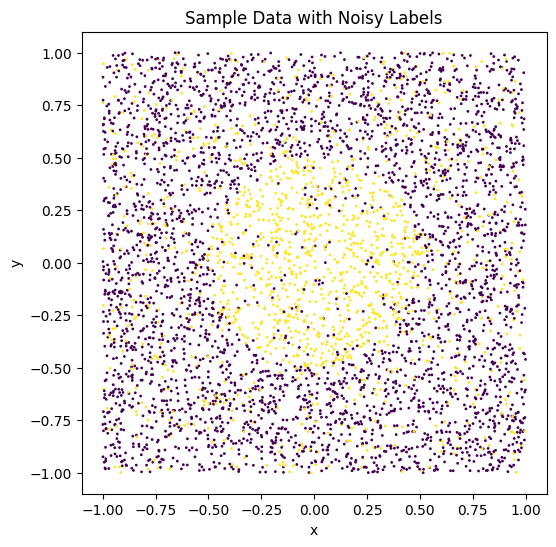

In [3]:
import matplotlib.pyplot as plt

# Plot the points
plt.figure(figsize=(6, 6))
plt.scatter(data[:,0], data[:,1], c=labels, cmap='viridis', s=1)
plt.title('Sample Data with Noisy Labels')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [3]:
# Convert the numpy arrays to PyTorch tensors
data_torch = torch.tensor(data, dtype=torch.float32)
labels_torch = torch.tensor(labels, dtype=torch.float32)
data_length = len(data_torch)
split_length = int(0.8*data_length)

train_data = data_torch[:split_length]
train_labels = labels_torch[:split_length]
val_data = data_torch[split_length:]
val_labels = labels_torch[split_length:]

print(train_data.shape, train_labels.shape)
print(val_data.shape, val_labels.shape)

torch.Size([4000, 2]) torch.Size([4000, 1])
torch.Size([1000, 2]) torch.Size([1000, 1])


In [4]:
g = torch.Generator().manual_seed(42)

def get_batch(data, labels, batch_size=256):
    # Generate random indices
    indices = torch.randint(0, len(data), size=(batch_size,), generator= g)

    # Select the data and labels at these indices
    data_batch = data[indices]
    labels_batch = labels[indices]

    return data_batch, labels_batch

data_batch, labels_batch = get_batch(train_data,train_labels)
print(data_batch.shape, labels_batch.shape)

torch.Size([256, 2]) torch.Size([256, 1])


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the model
input_size = 2
hidden_size = 4
output_size = 1

g.manual_seed(42)
torch.manual_seed(42)

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.seq_model = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, output_size)
    )
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.seq_model(x)

net = Net()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

for steps in range(100000):
  net.train()
  data_batch, labels_batch = get_batch(data_torch, labels_torch, batch_size=256)
  output = net(data_batch)
  loss = loss_fn(output, labels_batch)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if steps % 1000 == 0:
    net.eval()
    output = net(val_data)
    val_loss = loss_fn(output, val_labels)
    print(f"{steps} val_loss: {val_loss.item()}")
"""
Net 클래스: 입력층(2개) → 은닉층(4개, ReLU 활성화 함수) → 출력층(1개)으로 구성된 신경망입니다.

nn.BCEWithLogitsLoss(): 이진 분류(Binary Classification)에 사용되는 손실 함수입니다. 마지막 출력에 Sigmoid를 취하지 않아도 내부적으로 처리해 주어 수치적 안정성이 높습니다.

optim.SGD: 확률적 경사 하강법을 사용하여 가중치를 업데이트합니다.

학습 루프 부분
net.train(): 모델을 학습 모드로 설정합니다. (드롭아웃, 배치 정규화 등이 동작함)

optimizer.zero_grad(): 이전 단계에서 계산된 기울기(Gradient)를 초기화합니다. (하지 않으면 기울기가 누적되어 학습이 망가집니다.)

loss.backward(): 오차 역전파를 통해 각 가중치가 오차에 기여한 정도(기울기)를 계산합니다.
"""

0 val_loss: 0.9213314056396484
1000 val_loss: 0.6011289358139038
2000 val_loss: 0.5999171137809753
3000 val_loss: 0.5986946225166321
4000 val_loss: 0.5972920060157776
5000 val_loss: 0.5955888628959656
6000 val_loss: 0.5931885838508606
7000 val_loss: 0.5902618765830994
8000 val_loss: 0.5864421725273132
9000 val_loss: 0.5818878412246704
10000 val_loss: 0.5770291090011597
11000 val_loss: 0.5718410611152649
12000 val_loss: 0.5667085647583008
13000 val_loss: 0.5617899894714355
14000 val_loss: 0.5565539002418518
15000 val_loss: 0.5486124157905579
16000 val_loss: 0.5385783910751343
17000 val_loss: 0.529022216796875
18000 val_loss: 0.5205901861190796
19000 val_loss: 0.5133546590805054
20000 val_loss: 0.5069391131401062
21000 val_loss: 0.5016184449195862
22000 val_loss: 0.4974716007709503
23000 val_loss: 0.49398449063301086
24000 val_loss: 0.4913959205150604
25000 val_loss: 0.489406019449234
26000 val_loss: 0.48760002851486206
27000 val_loss: 0.48652783036231995
28000 val_loss: 0.48502185940742

(100000, 1)


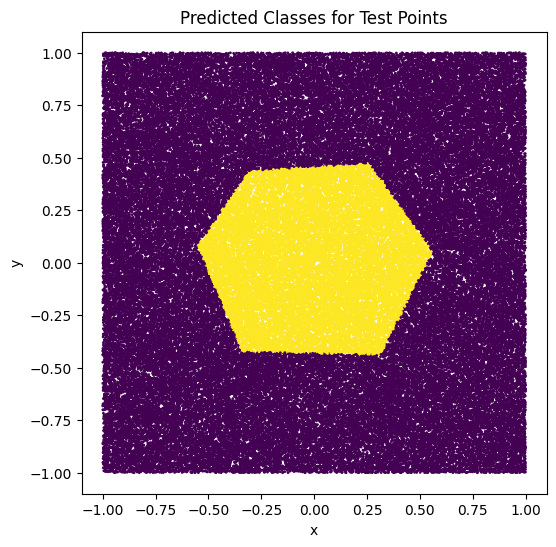

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Generate 10000 new points
n_points_test = 100000
points_test = np.random.uniform(-1, 1, (n_points_test, 2))
# Convert the points to a PyTorch tensor
points_test_torch = torch.from_numpy(points_test).float()

net.eval()
output_test = net(points_test_torch)

probabilities = torch.sigmoid(output_test)
predictions = (probabilities > 0.5).float()

# Convert the predictions to a numpy array
predictions_np = predictions.numpy()
print(predictions_np.shape)

# Plot the points, colored by their predicted class
plt.figure(figsize=(6, 6))
plt.scatter(points_test[:, 0], points_test[:, 1], c=predictions_np, cmap='viridis', s=1)
plt.title('Predicted Classes for Test Points')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
